In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import MatrixSymbol, Matrix, Identity
import sympy as sym
import control


# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Uso de librería "statsmodels"

Esta librería se usa mucho en aplicaciones estadísticas, pero tiene un compendio de métodos y funciones muy útiles para estimar modelos usando polinomios autorregresivos.

## Experimento de identificación

**Paso 1:** En este ejemplo cargamos datos exercise_05.csv.

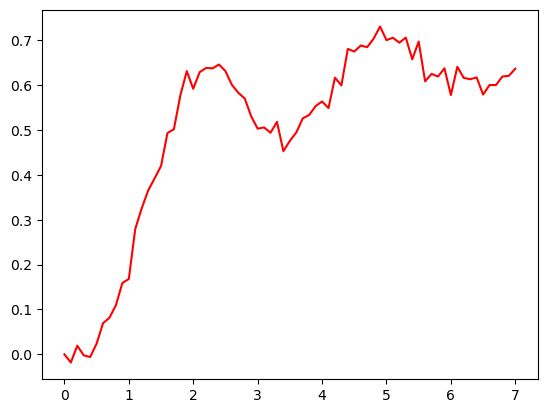

In [28]:
datos = pd.read_csv ('data\exercise_05.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = datos.un

y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)

for i in range(1,N):
    y_1[i] = yn[i-1]
    u_1[i] = u[i-1]
for i in range(2,N):
    y_2[i] = yn[i-2]
    u_2[i] = u[i-2]

    
datos['y_1'] = y_1    
datos['u_1'] = u_1
datos['y_2'] = y_2    
datos['u_2'] = u_2

dt = (t[1] - t[0])
plt.plot(t,yn,color = 'red')

**Paso 2:** A continuación, dividiremos los datos en conjuntos de entrenamiento y prueba:

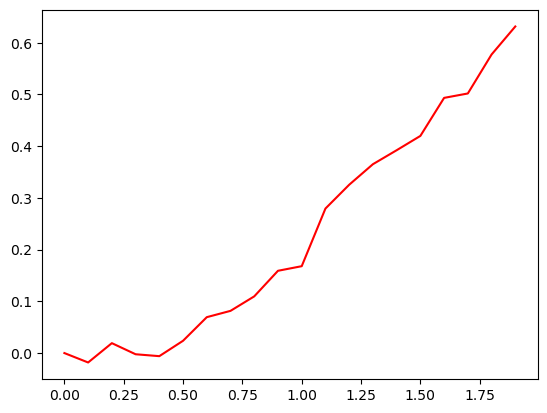

In [27]:
# Dividir los datos en conjuntos de entrenamiento y prueba
nobs_train = 20
train_data = datos[:nobs_train]
test_data = datos[nobs_train:]    
train_data['yn']
plt.plot(train_data['t'],train_data['yn'],color = 'red')

**Paso 3:** Ajustar un modelo a los datos de entrenamiento

In [30]:
# Crear matrices de diseño para los conjuntos de entrenamiento y prueba
exog_train = sm.add_constant(train_data[['y_1','y_2','u_1']])
exog_test = sm.add_constant(test_data[['yn','y_1','y_2','u_1']])

# Ajustar el modelo 
model = sm.OLS(train_data['yn'], exog_train).fit()

# Imprimir un resumen del modelo
print(model.params)

const   -0.000299
y_1      0.825918
y_2      0.262831
u_1      0.011531
dtype: float64


0.0068073155126161305


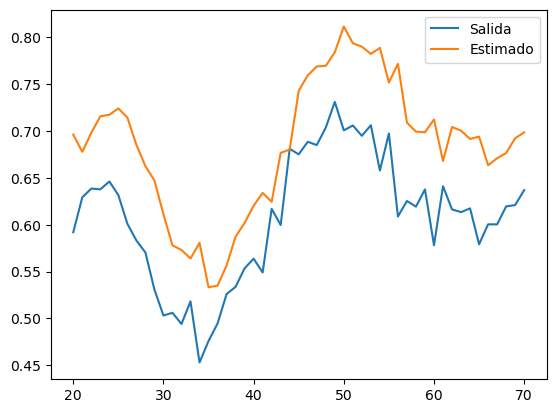

In [32]:
# Hacer predicciones en el conjunto de prueba
preds = model.predict(exog_test)

# Calcular el error cuadrático medio de las predicciones
mse = np.mean((preds - test_data['yn']) ** 2)

plt.plot(test_data['yn'])
plt.plot(preds)
plt.legend(['Salida','Estimado'])
print(mse)

In [33]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + model.params.y_1*z**-1 + model.params.y_2*z**-2
#B =  theta[3]*z**-1 +theta[4]*z**-2+theta[5]*z**-3  
B =  model.params.u_1*z**-1
## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

0.0115310593829128*z/(z**2 + 0.825917853430682*z + 0.262831366893003)

In [42]:
## Función de transferencia
G_e = control.tf([model.params.u_1,0],[1,-model.params.y_1,-model.params.y_2],dt)
G_e

TransferFunction(array([0.01153106, 0.        ]), array([ 1.        , -0.82591785, -0.26283137]), 0.1)

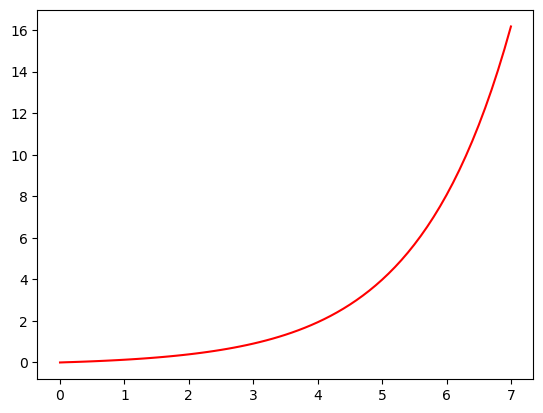

In [43]:
## Se determina la respuesta estimada al escalón
_,ye = control.step_response(G_e,t)
plt.plot(t,ye,color = 'red')
